# **PTST**

Includes shear test 3D, tensile test axisymm, investigation of state variables profile at ligament

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D_compression
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy

In [2]:
def get_damage(m):   
    radial_damage = []
    hoop_damage = []
    shear_damage = []

    for i in range(len(m.hist.state_vars)):
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        delta = m_inelastic.DELTA

        beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        radial_damage.append(1-(beta_ijkl**2)[0,1,1,1,1])
        hoop_damage.append(1-(beta_ijkl**2)[0,2,2,2,2])
        shear_damage.append(1-((beta_ijkl)[0,1,0,1,0]*2)**2)
    return radial_damage, hoop_damage, shear_damage


In [3]:
def get_omega_N(m):
    omega_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_N_11[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_N_01[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
    return omega_N_01, omega_N_11 

In [4]:
def get_omega_T(m):
    omega_T_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_T_11[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_T_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_T_01[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        
    return omega_T_01, omega_T_11   

In [5]:
def get_sigma_N(m):
    
    sigma_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        sigma_N_11[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
        
    sigma_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        sigma_N_01[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
    
    sigma_radial = np.zeros(len(m.hist.state_vars))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        eps_T_pi_Emna = np.average(m.hist.state_vars[i][0]['eps_T_pi_Emna'],axis=1)
        eps_N_p_Emn = np.average(m.hist.state_vars[i][0]['eps_N_p_Emn'],axis=1)
        
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        delta = m_inelastic.DELTA

        beta_Emabcd = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        D_Emabcd = np.einsum(
                     '...ijab, abef, ...cdef->...ijcd',
                     beta_Emabcd, m_inelastic.D_abef, beta_Emabcd
                )

        eps_p_Emab = (
        np.einsum('n,...n,na,nb->...ab',
                  m_inelastic._MPW, eps_N_p_Emn, m_inelastic._MPN, m_inelastic._MPN) +
        0.5 * (
                np.einsum('n,...nf,na,fb->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA) +
                np.einsum('n,...nf,nb,fa->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA)
        )
        )
        eps_e_Emab = eps_Emab - eps_p_Emab

        sig_Emab = np.einsum(
            '...abcd,...cd,...ab->...ab',
            D_Emabcd, eps_e_Emab, m_inelastic.DELTA
                ) 
        sigma_11 = sig_Emab[0,:,1,1]
        sigma_radial[i] = max(sigma_11)
        
    return sigma_N_01, sigma_N_11, sigma_radial

In [92]:
mat_param =  dict(E = 37e+3, 
        nu = 0.0, 
        Ad_tension = 800.0, 
        eps_0_tension = 1e-5,
        Ad_compression = 500.0, 
        eps_0_compression = 1e-3,
        K_N = 0.,   
        sigma_N_0 = 50.,
        gamma_N = 80000.,  
        sigma_T_0 = 10.0, 
        K_T = 0.0, 
        gamma_T = 5000,
        S_T = 0.01,   
        c_T = 10, 
        r_T = 13,   
        m_T = 0.0, 
        p_T = 6.0)

# E = 39000
# nu = 0.2
# mp = dict(          
# Ad = 700,
# eps_0  = 0.00001,
# sig_0  = 50,
# K_N = 0,
# gamma_N = 80000,
# sigma_T_0  = 10.0,
# K_T  = 0,
# gamma_T  = 5000,
# S_T  = 0.01,
# c_T  = 10,
# r_T  = 13,
# a  = 0.5,
# e_T  = 6.0) 

## Complete PTST - study about state variables profiles

In [123]:
n_x_e = 10
n_inner_y_e = 5
n_outer_y_e = 5
L_x = 50.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 20
n_notch = 4
# geo_transform
# gmesh
xd_inner = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, 0),
                               coord_max=(L_x, R_in),
                               shape=(n_x_e, n_inner_y_e),
                               fets=FETS2D4Q())
xd_middle = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())
xd_outer = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, R_in+dR),
                               coord_max=(L_x, R_out),
                               shape=(n_x_e, n_outer_y_e),
                               fets=FETS2D4Q())
# m_elastic = MATS3DElastic(E=40000, nu=0.18)
# m_inelastic_MDM = MATS3DMplDamageEEQ(**CAxisymmMDM)


m_inelastic = MS13D_compression(**mat_param)

m = TStepBC(
    domains=[(xd_inner, m_inelastic),
             (xd_outer, m_inelastic),
             (xd_middle, m_inelastic),
             ]
)

## Boundary and transition conditions

In [124]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

### Kinematic links between the domains

In [125]:
link_inner_middle_0 = BCSliceI(var='u', dims=[0],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_inner_middle_1 = BCSliceI(var='u', dims=[1],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

link_middle_outer_0 = BCSliceI(var='u', dims=[0],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_middle_outer_1 = BCSliceI(var='u', dims=[1],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

# link_middle_outer = BCSliceI(var='u', dims=[0, 1],
#                              slice=xd_middle.mesh.I[n_notch:-n_notch, 0], 
#                              # slice=xd_outer.mesh.I[:, 0], 
#                              link_slice=xd_outer.mesh.I[:, -1],
#                              link_coeffs=[1, 1],
#                              link_dims=[0, 1],
#                              value=0,
#                             )

## Sliding dc + Precompression fc

In [126]:
inner_fixed_1 = BCSliceI(slice=xd_inner.mesh.I[:, 0], var='u', dims=[1], value=0)
outer_fixed_0 = BCSliceI(slice=xd_outer.mesh.I[0, :], var='u', dims=[0], value=0)
outer_fixed_1 = BCSliceI(slice=xd_outer.mesh.I[:, -1], var='u', dims=[1], value=0)

inner_fixed_out_1 = BCSliceI(slice=xd_inner.mesh.I[:, -1], var='u', dims=[1], value=0)

slide = 1.00
inner_slide_slice = BCSliceI(slice=xd_inner.mesh.I[-1, :],
                                   var='u', dims=[0], value=-0.1)

slide_control_dofs = inner_slide_slice.dofs
inner_slide = [BCDof(var='u', dof=dof, value=-slide, time_function=tf_sliding) 
                     for dof in slide_control_dofs ]


outer_compression_slice = BCSliceI(slice=xd_outer.mesh.I[:, -1],
                                   var='u', dims=[1], value=-0.1)

compression_dofs = outer_compression_slice.dofs
compression_stress = -1
compression_force = compression_stress  * 2* np.pi* R_out * L_x / len(compression_dofs)
outer_compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]

compression_dofs_inner = inner_fixed_out_1.dofs
outer_compression_force_inner_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs_inner ]


# outer_compression_force_first = [BCDof(var='u', dof=dof, value=0.01, time_function=tf_precrompression) 
#                                  for dof in compression_dofs ]
outer_compression_force_first[0].value *=0.5
outer_compression_force_first[-1].value *=0.5
outer_compression_force_inner_first[0].value *=0.5
outer_compression_force_inner_first[-1].value *=0.5

bc1 =   [inner_fixed_1,
        outer_fixed_0,
        link_middle_outer_0,
         link_middle_outer_1,
        link_inner_middle_0,
         link_inner_middle_1
        ]  + inner_slide + outer_compression_force_first

In [127]:
ligament_upper_slide_slice = BCSliceI(slice=xd_middle.mesh.I[:, -1],
                                   var='u', dims=[0], value=-0.1)
ligament_upper_slide_dofs = ligament_upper_slide_slice.dofs

ligament_lower_slide_slice = BCSliceI(slice=xd_middle.mesh.I[:, 0],
                                   var='u', dims=[0], value=-0.1)
ligament_lower_slide_dofs = ligament_lower_slide_slice.dofs

ligament_upper_confinement_slice = BCSliceI(slice=xd_middle.mesh.I[:, -1],
                                   var='u', dims=[1], value=-0.1)
ligament_upper_confinement_dofs = ligament_upper_confinement_slice.dofs

ligament_lower_confinement_slice = BCSliceI(slice=xd_middle.mesh.I[:, 0],
                                   var='u', dims=[1], value=-0.1)
ligament_lower_confinement_dofs = ligament_lower_confinement_slice.dofs

In [128]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains

In [129]:
s.reset()
s.run()

t:	 0.00(0), 
	 0.01(1), 
	 0.02(1), 
	 0.03(1), 
	 0.04(1), 
	 0.05(1), 
	 0.06(1), 
	 0.07(1), 
	 0.08(1), 
	 0.09(1), 
	 0.10(1), 
	 0.11(10), 
	 0.12(32), 
	 0.13

RuntimeError: Factor is exactly singular

## Postprocesing

### Access the last displacement step

In [130]:
F = m.hist.F_t
U = m.hist.U_t

In [131]:
F_slide = np.sum(F[:, slide_control_dofs], axis=-1)
F_slide_ligament_upper = np.sum(F[:, ligament_upper_slide_dofs], axis=-1)
F_slide_ligament_lower = np.sum(F[:, ligament_lower_slide_dofs], axis=-1)
F_confinement_ligament_upper = np.sum(F[:, ligament_upper_confinement_dofs], axis=-1)
F_confinement_ligament_lower = np.sum(F[:, ligament_lower_confinement_dofs], axis=-1)
U_slide = np.average(U[:, slide_control_dofs], axis=-1)
U_slide_ligament_upper = np.average(U[:, ligament_upper_slide_dofs], axis=-1)
U_slide_ligament_lower = np.average(U[:, ligament_lower_slide_dofs], axis=-1)
U_slide_differential_ligament = U_slide_ligament_upper - U_slide_ligament_lower

In [132]:
_, ax = plt.subplots(1,1)
ax.plot(-U_slide, -F_slide/1000)
ax.set_ylabel('Force [kN]')
ax.set_xlabel('Displacement at control[mm]')
# ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Displacement at control[mm]')

In [133]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Unit element Axisymm

In [66]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 4 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [67]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [68]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


In [73]:
factor = 1

# Boundary conditions with inner side fixed

slide = 0.05
compression_stress = -0

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice

compression_force = compression_stress  * 2 * np.pi* R_out * L_x / len(confinement_upper_dofs)
upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in confinement_upper_dofs ]
upper_compression_force[0].value *=0.5
upper_compression_force[-1].value *=0.5

slide_upper = [BCDof(var='u', dof=dof, value=slide , time_function=tf_sliding) 
                     for dof in slide_upper_dofs ]
bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper #+ upper_compression_force

# Boundary conditions with differential definition of ligament bc

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice
delta_dilatancy = U[:, ligament_upper_confinement_dofs] - U[:, ligament_lower_confinement_dofs]
delta_confinement = F[:, ligament_upper_confinement_dofs] - F[:, ligament_lower_confinement_dofs]
delta_slide = U[:, ligament_upper_slide_dofs] - U[:, ligament_lower_slide_dofs]

confinement_upper_0 = BCDof(var='u', dof=confinement_upper_dofs[0], value=delta_dilatancy[-1,0]*factor, time_function=tf_sliding)
confinement_upper_1 = BCDof(var='u', dof=confinement_upper_dofs[1], value=delta_dilatancy[-1,1]*factor, time_function=tf_sliding)
confinement_upper_2 = BCDof(var='u', dof=confinement_upper_dofs[2], value=delta_dilatancy[-1,2]*factor, time_function=tf_sliding)
confinement_upper_3 = BCDof(var='u', dof=confinement_upper_dofs[3], value=delta_dilatancy[-1,3]*factor, time_function=tf_sliding)

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=delta_slide[-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=delta_slide[-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=delta_slide[-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=delta_slide[-1,3]*factor, time_function=tf_sliding)


bc2 =   [confinement_upper_0, slide_upper_0,
        confinement_upper_1, slide_upper_1,
        confinement_upper_2, slide_upper_2,
        confinement_upper_3, slide_upper_3,
        inner_fixed_0, inner_fixed_1] 


# Boundary conditions with differential slide definition of ligament bc

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice
delta_slide = U[:, ligament_upper_slide_dofs] - U[:, ligament_lower_slide_dofs]

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=delta_slide[-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=delta_slide[-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=delta_slide[-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=delta_slide[-1,3]*factor, time_function=tf_sliding)


bc3 =   [slide_upper_0,
        slide_upper_1, 
        slide_upper_2, 
        slide_upper_3, 
        inner_fixed_0, inner_fixed_1] 

# Boundary conditions with full definition of ligament bc


confinement_upper_0 = BCDof(var='f', dof=confinement_upper_dofs[0], value=F[:, ligament_upper_confinement_dofs][-1,0]*factor, time_function=tf_sliding)
confinement_upper_1 = BCDof(var='f', dof=confinement_upper_dofs[1], value=F[:, ligament_upper_confinement_dofs][-1,1]*factor, time_function=tf_sliding)
confinement_upper_2 = BCDof(var='f', dof=confinement_upper_dofs[2], value=F[:, ligament_upper_confinement_dofs][-1,2]*factor, time_function=tf_sliding)
confinement_upper_3 = BCDof(var='f', dof=confinement_upper_dofs[3], value=F[:, ligament_upper_confinement_dofs][-1,3]*factor, time_function=tf_sliding)

confinement_lower_0 = BCDof(var='f', dof=confinement_lower_dofs[0], value=F[:, ligament_lower_confinement_dofs][-1,0]*factor, time_function=tf_sliding)
confinement_lower_1 = BCDof(var='f', dof=confinement_lower_dofs[1], value=F[:, ligament_lower_confinement_dofs][-1,1]*factor, time_function=tf_sliding)
confinement_lower_2 = BCDof(var='f', dof=confinement_lower_dofs[2], value=F[:, ligament_lower_confinement_dofs][-1,2]*factor, time_function=tf_sliding)
confinement_lower_3 = BCDof(var='f', dof=confinement_lower_dofs[3], value=F[:, ligament_lower_confinement_dofs][-1,3]*factor, time_function=tf_sliding)

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=U[:, ligament_upper_slide_dofs][-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=U[:, ligament_upper_slide_dofs][-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=U[:, ligament_upper_slide_dofs][-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=U[:, ligament_upper_slide_dofs][-1,3]*factor, time_function=tf_sliding)

slide_lower_0 = BCDof(var='u', dof=slide_lower_dofs[0], value=U[:, ligament_lower_slide_dofs][-1,0]*factor, time_function=tf_sliding)
slide_lower_1 = BCDof(var='u', dof=slide_lower_dofs[1], value=U[:, ligament_lower_slide_dofs][-1,1]*factor, time_function=tf_sliding)
slide_lower_2 = BCDof(var='u', dof=slide_lower_dofs[2], value=U[:, ligament_lower_slide_dofs][-1,2]*factor, time_function=tf_sliding)
slide_lower_3 = BCDof(var='u', dof=slide_lower_dofs[3], value=U[:, ligament_lower_slide_dofs][-1,3]*factor, time_function=tf_sliding)


bc4 =   [confinement_upper_0, confinement_lower_0, slide_upper_0, slide_lower_0,
        confinement_upper_1, confinement_lower_1, slide_upper_1, slide_lower_1,
        confinement_upper_2, confinement_lower_2, slide_upper_2, slide_lower_2,
        confinement_upper_3, confinement_lower_3, slide_upper_3, slide_lower_3
            ] 

IndexError: index 2 is out of bounds for axis 0 with size 2

In [72]:
m1 = copy.deepcopy(m)
m1.bc=bc1
m1.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s1 = m1.sim
s1.tloop.verbose = False
s1.tloop.k_max = 1000
s1.tline.step = 0.005/factor
# Accessing the following property - ensures serialization
s1.tstep.fe_domain.serialized_subdomains
s1.reset()
s1.run()

KeyboardInterrupt: 

In [ ]:
U_t1 = np.average(m1.hist.U_t[:, slide_upper_dofs] - m1.hist.U_t[:, slide_lower_dofs], axis=-1)
F_t1 = np.sum(m1.hist.F_t[:, slide_upper_dofs], axis=-1)

In [ ]:
m2 = copy.deepcopy(m)
m2.bc=bc2
m2.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s2 = m2.sim
s2.tloop.verbose = False
s2.tloop.k_max = 1000
s2.tline.step = 0.005/factor
# Accessing the following property - ensures serialization
s2.tstep.fe_domain.serialized_subdomains
s2.reset()
s2.run()

In [ ]:
U_t2 = np.average(m2.hist.U_t[:, slide_upper_dofs] - m2.hist.U_t[:, slide_lower_dofs], axis=-1)
F_t2 = np.sum(m2.hist.F_t[:, slide_upper_dofs], axis=-1)

In [429]:
# m3 = copy.deepcopy(m)
# m3.bc=bc3
# m3.hist.vis_record = {
# #    'strain': Vis3DTensorField(var='eps_ab'),
#     'stress': Vis3DTensorField(var='sig_ab'),
#     #        'kinematic hardening': Vis3DStateField(var='z_a')
# }

# s3 = m3.sim
# s3.tloop.verbose = False
# s3.tloop.k_max = 1000
# s3.tline.step = 0.005/factor
# # Accessing the following property - ensures serialization
# s3.tstep.fe_domain.serialized_subdomains
# s3.reset()
# s3.run()

In [408]:
# U_t3 = np.average(m3.hist.U_t[:, slide_upper_dofs] - m3.hist.U_t[:, slide_lower_dofs], axis=-1)
# F_t3 = np.sum(m3.hist.F_t[:, slide_upper_dofs], axis=-1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
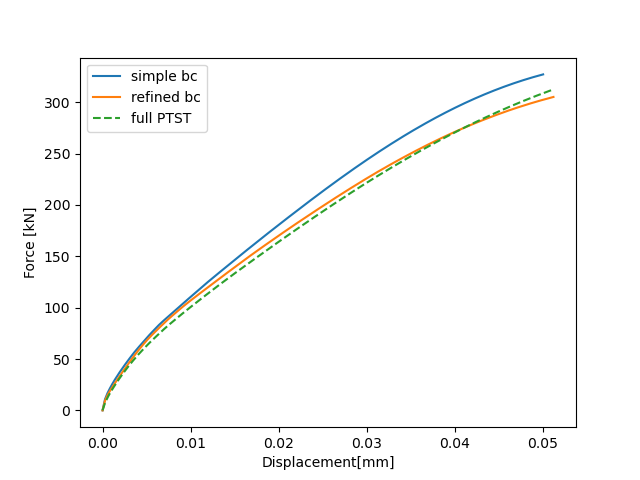

In [461]:
fig, (ax1) = plt.subplots(1)
ax1.plot(U_t1, F_t1/1000, label='simple bc')
ax1.plot(U_t2, F_t2/1000, label='refined bc')
# ax1.plot(U_t3, F_t3/1000, label='transferred bc')
ax1.plot(U_slide_differential_ligament, -F_slide/1000, '--', label='full PTST')
ax1.set_ylabel('Force [kN]')
ax1.set_xlabel('Displacement[mm]')
ax1.legend()
# ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
# # ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
# # ax2.set_ylabel('Stress [MPa]')
# # ax2.set_xlabel('Strain[-]')
# G = np.trapz(F_t, x=U_t)/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x))*1000
# G2 = np.trapz(F_t/(2 * np.pi * (R_in+dR)), x=U_t/(L_x-n_notch*2*d_x))
# print(G)
# print(G2)
# print(max(-F_t/1000))

In [315]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [137]:
# m.fe_domain[2].state_k

## Postprocesing

### Study about slide profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
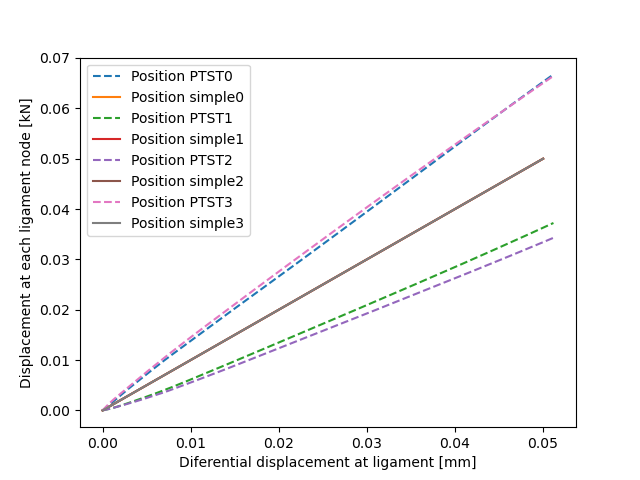

In [462]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], '--', label='Position PTST' + str(i))
    ax.plot(U_t1, m1.hist.U_t[:, slide_upper_dofs][:,i] - m1.hist.U_t[:, slide_lower_dofs][:,i], label='Position simple' + str(i))
ax.set_ylabel('Displacement at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()



### Study about slide profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
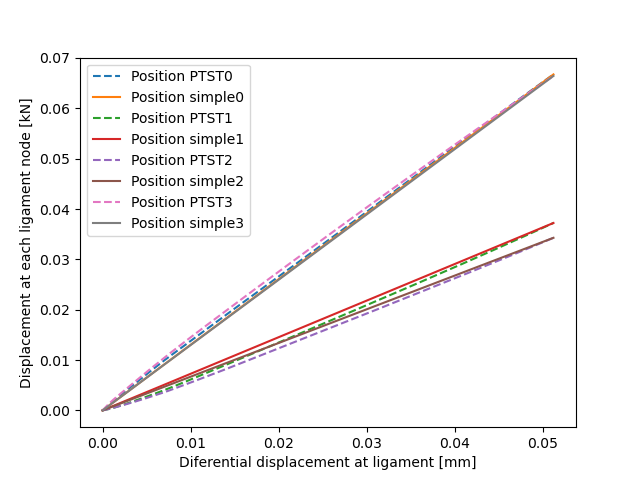

In [463]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], '--', label='Position PTST' + str(i))
    ax.plot(U_t2, m2.hist.U_t[:, slide_upper_dofs][:,i] - m2.hist.U_t[:, slide_lower_dofs][:,i], label='Position simple' + str(i))
ax.set_ylabel('Displacement at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about confinement profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
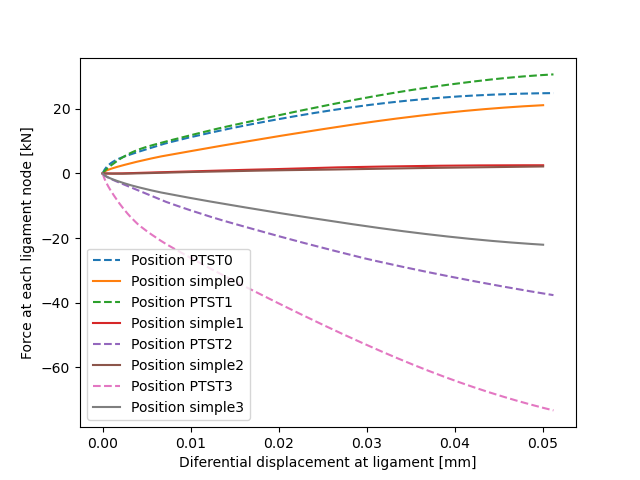

In [464]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, '--', label='Position PTST' + str(i))
    ax.plot(U_t1, (m1.hist.F_t[:, confinement_upper_dofs][:,i]- m1.hist.F_t[:, confinement_lower_dofs][:,i])/1000, label='Position simple' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about slide profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
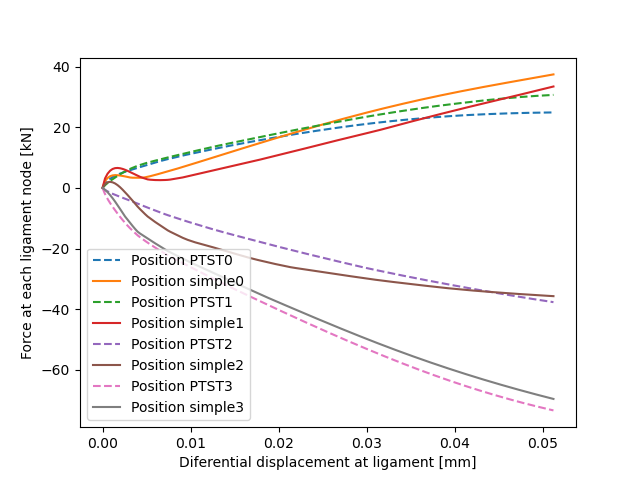

In [465]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, '--',label='Position PTST' + str(i))
    ax.plot(U_t2, (m2.hist.F_t[:, confinement_upper_dofs][:,i] - m2.hist.F_t[:, confinement_lower_dofs][:,i])/1000, label='Position simple' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about dilatancy profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
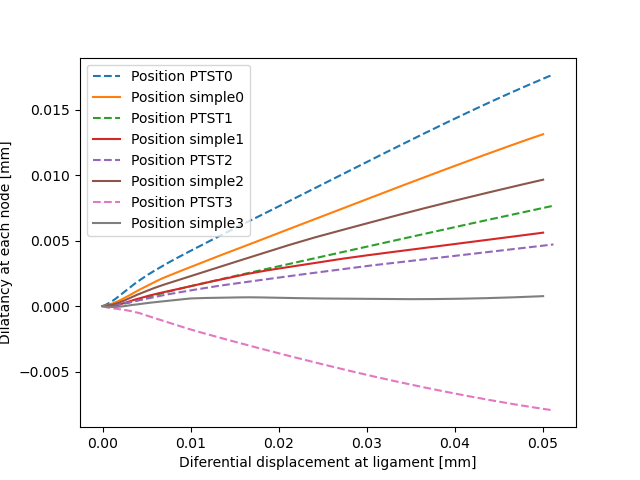

In [466]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], '--', label = 'Position PTST' + str(i))
    ax.plot(U_t1, (m1.hist.U_t[:, confinement_upper_dofs][:,i] - m1.hist.U_t[:, confinement_lower_dofs][:,i]), label='Position simple' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()


### Study about dilatancy profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
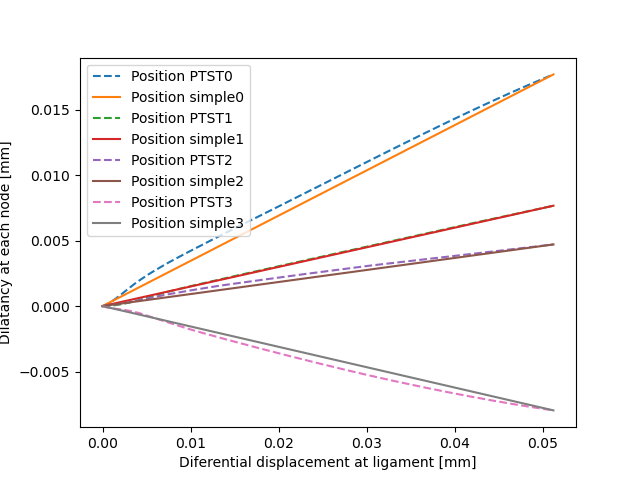

In [467]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], '--', label = 'Position PTST' + str(i))
    ax.plot(U_t2, (m2.hist.U_t[:, confinement_upper_dofs][:,i] - m2.hist.U_t[:, confinement_lower_dofs][:,i]), label='Position simple' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()
